#  Import

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

# Modelling
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing        # for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing      # for Simple Exponential Smoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('final_data.csv')
df.head(10)

,date,volume,is_holiday
0,2019-01-01,5.0,True
1,2019-01-02,558.0,False
2,2019-01-03,455.0,False
3,2019-01-04,418.0,False
4,2019-01-05,198.0,False
5,2019-01-06,0.0,False
6,2019-01-07,480.0,False
7,2019-01-08,426.0,False
8,2019-01-09,413.0,False
9,2019-01-10,407.0,False


In [3]:
df.shape

(364, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        364 non-null    object 
 1   volume      364 non-null    float64
 2   is_holiday  364 non-null    bool   
dtypes: bool(1), float64(1), object(1)
memory usage: 6.2+ KB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        364 non-null    datetime64[ns]
 1   volume      364 non-null    float64       
 2   is_holiday  364 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 6.2 KB


In [6]:
df.describe()

,date,volume
count,364,364.000000
mean,2019-07-01 20:54:03.956044032,288.041209
min,2019-01-01 00:00:00,0.000000
25%,2019-04-01 18:00:00,122.000000
50%,2019-07-01 12:00:00,370.000000
75%,2019-10-01 06:00:00,425.250000
max,2019-12-31 00:00:00,615.000000
std,NaN,185.711901


In [7]:
df.tail()

,date,volume,is_holiday
359,2019-12-27,338.0,False
360,2019-12-28,103.0,False
361,2019-12-29,0.0,False
362,2019-12-30,391.0,False
363,2019-12-31,305.0,False


# ARIMA

In [8]:
time_series = df['volume']
model = ARIMA(time_series, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2397.240
Date:                Fri, 01 Sep 2023   AIC                           4800.481
Time:                        00:45:35   BIC                           4812.164
Sample:                             0   HQIC                          4805.125
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3017      0.050      6.012      0.000       0.203       0.400
ma.L1         -0.9998      0.355     -2.818      0.005      -1.695      -0.304
sigma2      3.144e+04   1.25e+04      2.524      0.0

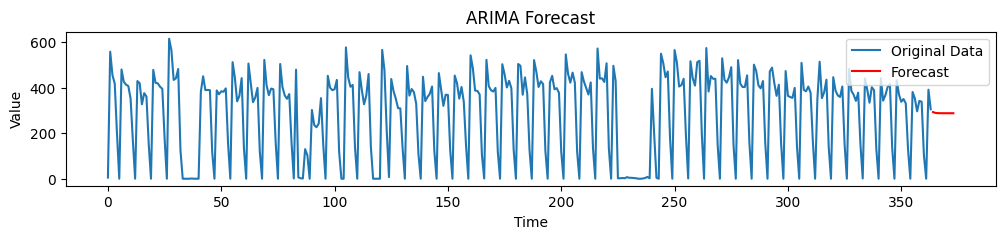

In [9]:
# Forecast the next 'n' steps
n_forecast = 10
forecast = model_fit.forecast(steps=n_forecast)

# Plot original data and forecast
plt.figure(figsize=(12, 2))
plt.plot(time_series, label='Original Data')
plt.plot(np.arange(len(time_series), len(time_series) + n_forecast), forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Decision Trees

In [10]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = df['date'].dt.isocalendar().day
df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['is_month_start'] = pd.DatetimeIndex(df['date']).is_month_start
df['is_month_end'] = pd.DatetimeIndex(df['date']).is_month_end
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            364 non-null    datetime64[ns]
 1   volume          364 non-null    float64       
 2   is_holiday      364 non-null    bool          
 3   month           364 non-null    int32         
 4   day             364 non-null    UInt32        
 5   dayofyear       364 non-null    int32         
 6   weekofyear      364 non-null    UInt32        
 7   weekday         364 non-null    int32         
 8   quarter         364 non-null    int32         
 9   is_month_start  364 non-null    bool          
 10  is_month_end    364 non-null    bool          
dtypes: UInt32(2), bool(3), datetime64[ns](1), float64(1), int32(4)
memory usage: 16.1 KB


In [11]:
df = df.drop(['date'], axis = 1) 
df.head()

,volume,is_holiday,month,day,dayofyear,weekofyear,weekday,quarter,is_month_start,is_month_end
0,5.0,True,1,2,1,1,1,1,True,False
1,558.0,False,1,3,2,1,2,1,False,False
2,455.0,False,1,4,3,1,3,1,False,False
3,418.0,False,1,5,4,1,4,1,False,False
4,198.0,False,1,6,5,1,5,1,False,False


In [12]:
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='month')
df = pd.get_dummies(df, columns=['weekday'], drop_first=True, prefix='wday')
df = pd.get_dummies(df, columns=['quarter'], drop_first=True, prefix='qrtr')
df = pd.get_dummies(df, columns=['is_month_start'], drop_first=True, prefix='m_start')
df = pd.get_dummies(df, columns=['is_month_end'], drop_first=True, prefix='m_end')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   volume        364 non-null    float64
 1   is_holiday    364 non-null    bool   
 2   day           364 non-null    UInt32 
 3   dayofyear     364 non-null    int32  
 4   weekofyear    364 non-null    UInt32 
 5   month_2       364 non-null    bool   
 6   month_3       364 non-null    bool   
 7   month_4       364 non-null    bool   
 8   month_5       364 non-null    bool   
 9   month_6       364 non-null    bool   
 10  month_7       364 non-null    bool   
 11  month_8       364 non-null    bool   
 12  month_9       364 non-null    bool   
 13  month_10      364 non-null    bool   
 14  month_11      364 non-null    bool   
 15  month_12      364 non-null    bool   
 16  wday_1        364 non-null    bool   
 17  wday_2        364 non-null    bool   
 18  wday_3        364 non-null    

In [13]:
x = df.drop(['volume'], axis=1)
y = df['volume']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=88)
print(X_train.shape, X_test.shape)

(291, 26) (73, 26)


### Random Forest

In [14]:
#Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=88)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

23.720145127712122
0.984123275308611
45.53402369326293
0.9295081018247456


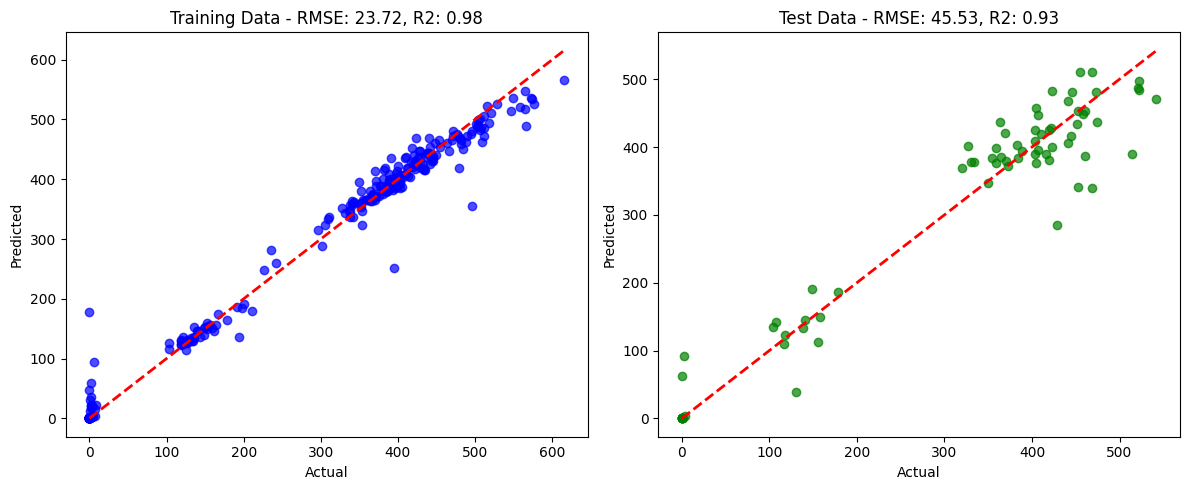

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Assuming you've defined X_train, y_train, X_test, and y_test

# Train the Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=88)
model_rf.fit(X_train, y_train)

# Predictions on training data
pred_train_rf = model_rf.predict(X_train)

# Metrics on training data
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train_rf))
r2_train = r2_score(y_train, pred_train_rf)

# Predictions on test data
pred_test_rf = model_rf.predict(X_test)

# Metrics on test data
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test_rf))
r2_test = r2_score(y_test, pred_test_rf)

# Create scatter plots for training and test data
plt.figure(figsize=(12, 5))

# Training data scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, pred_train_rf, color='blue', alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Training Data - RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}')

# Test data scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test_rf, color='green', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Data - RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}')

plt.tight_layout()
plt.show()


### Trees

In [16]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [17]:
# Code lines 1 to 3
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

# Code lines 4 to 6
pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))

117.8896644003661
0.6078269976103685
103.66980368705865
0.6345973445601925


In [18]:
# Code Lines 1 to 4: Fit the regression tree 'dtree1' and 'dtree2' 
dtree1 = DecisionTreeRegressor(max_depth=2)
dtree2 = DecisionTreeRegressor(max_depth=5)
dtree1.fit(X_train, y_train)
dtree2.fit(X_train, y_train)

# Code Lines 5 to 6: Predict on training data
tr1 = dtree1.predict(X_train)
tr2 = dtree2.predict(X_train) 

#Code Lines 7 to 8: Predict on testing data
y1 = dtree1.predict(X_test)
y2 = dtree2.predict(X_test)

In [19]:
# Print RMSE and R-squared value for regression tree 'dtree1' on training data
print(np.sqrt(mean_squared_error(y_train,tr1))) 
print(r2_score(y_train, tr1))

# Print RMSE and R-squared value for regression tree 'dtree1' on testing data
print(np.sqrt(mean_squared_error(y_test,y1))) 
print(r2_score(y_test, y1))

103.03151423078118
0.7004520198464261
89.5225370164792
0.7275217072289477


In [20]:
# Print RMSE and R-squared value for regression tree 'dtree2' on training data
print(np.sqrt(mean_squared_error(y_train,tr2))) 
print(r2_score(y_train, tr2))

# Print RMSE and R-squared value for regression tree 'dtree2' on testing data
print(np.sqrt(mean_squared_error(y_test,y2))) 
print(r2_score(y_test, y2))

64.75986890159653
0.8816582050626258
55.59236690386453
0.8949254649873682


# SARIMA

In [21]:
sarima_df = pd.read_csv('final_data.csv')
sarima_df.head(5)

,date,volume,is_holiday
0,2019-01-01,5.0,True
1,2019-01-02,558.0,False
2,2019-01-03,455.0,False
3,2019-01-04,418.0,False
4,2019-01-05,198.0,False


In [22]:
sarima_df['date'] = pd.to_datetime(sarima_df['date'])
sarima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        364 non-null    datetime64[ns]
 1   volume      364 non-null    float64       
 2   is_holiday  364 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 6.2 KB


In [23]:
sarima_df = sarima_df[['date', 'volume']].set_index('date')
sarima_df = sarima_df.asfreq('D')
sarima_df.head()

,volume
date,
2019-01-01,5.0
2019-01-02,558.0
2019-01-03,455.0
2019-01-04,418.0
2019-01-05,198.0


In [24]:
sarima_df.fillna(0, inplace=True)
sarima_df.isna().sum()

volume    0
dtype: int64

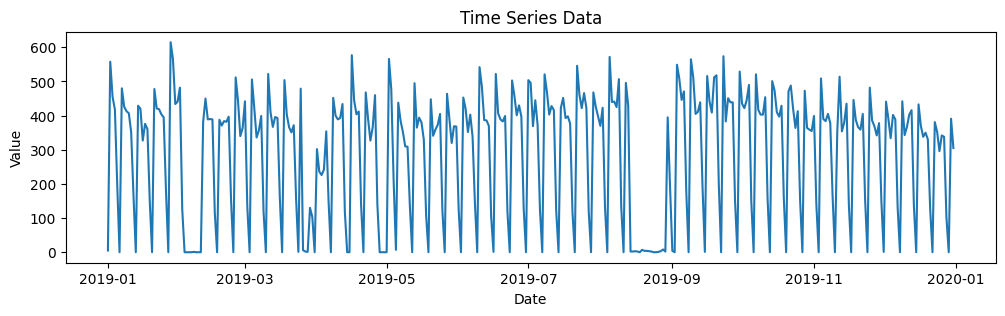

In [25]:
plt.figure(figsize=(12, 3))
plt.plot(sarima_df)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

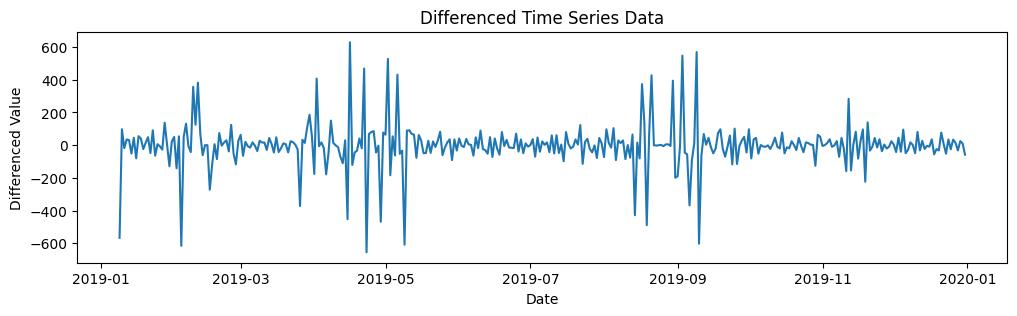

In [26]:
data_diff = diff(sarima_df['volume'], k_diff=1, k_seasonal_diff=1, seasonal_periods=7)
plt.figure(figsize=(12, 3))
plt.plot(data_diff)
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.title('Differenced Time Series Data')
plt.show()

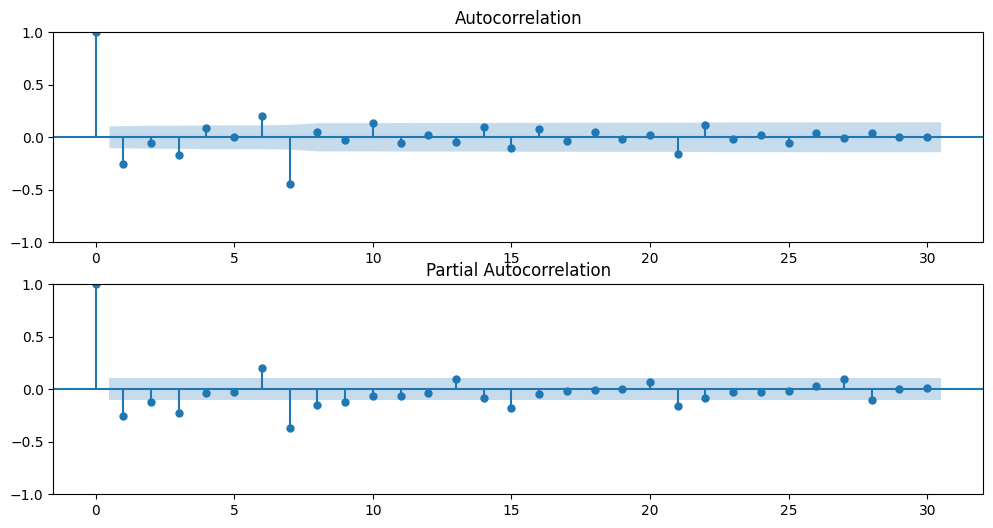

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(data_diff, lags=30, ax=ax1)
plot_pacf(data_diff, lags=30, ax=ax2)
plt.show()

In [28]:
sarima_train, sarima_test = sarima_df[:-60], sarima_df[-60:]
sarima_train.shape, sarima_test.shape

((305, 1), (60, 1))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05886D+00    |proj g|=  5.55808D-02

At iterate    5    f=  6.02279D+00    |proj g|=  1.21162D-02

At iterate   10    f=  6.01898D+00    |proj g|=  7.11053D-03

At iterate   15    f=  5.95772D+00    |proj g|=  6.50865D-03

At iterate   20    f=  5.95602D+00    |proj g|=  6.80677D-04

At iterate   25    f=  5.95597D+00    |proj g|=  6.31477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   

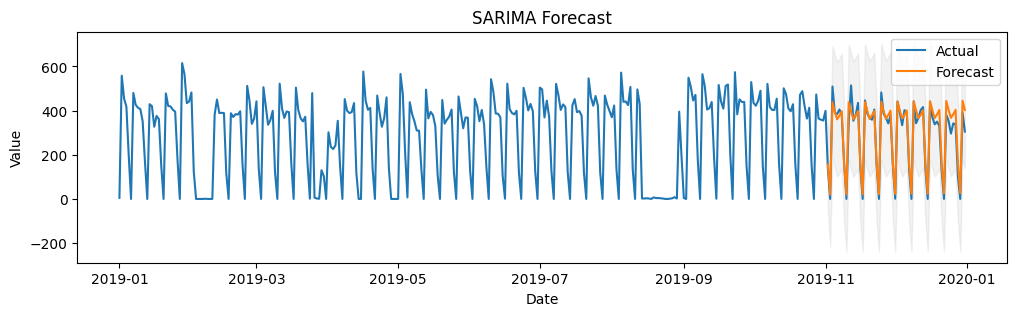

In [29]:
sarima_model = SARIMAX(sarima_train, order = (2,1,2), seasonal_order = (0,1,1,7))
sarima_result = sarima_model.fit()

forecast_steps = 60  # Number of steps ahead to forecast
forecast = sarima_result.get_forecast(steps=forecast_steps)

forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 3))
plt.plot(sarima_df.index, sarima_df, label='Actual')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


In [30]:
r2_score(sarima_test, forecast_mean)

0.93813848043518

# Exponential Smoothing

In [31]:
es_df = pd.read_csv('final_data.csv')
es_df.isna().sum()

date          0
volume        0
is_holiday    0
dtype: int64

In [32]:
es_df['date'] = pd.to_datetime(es_df['date'])
es_df = es_df[['date', 'volume']].set_index('date')
es_df = es_df.asfreq('D')
es_df.fillna(0, inplace=True)
es_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [33]:
y_train, y_test = es_df.iloc[:-28, 0], es_df.iloc[-28:, 0]

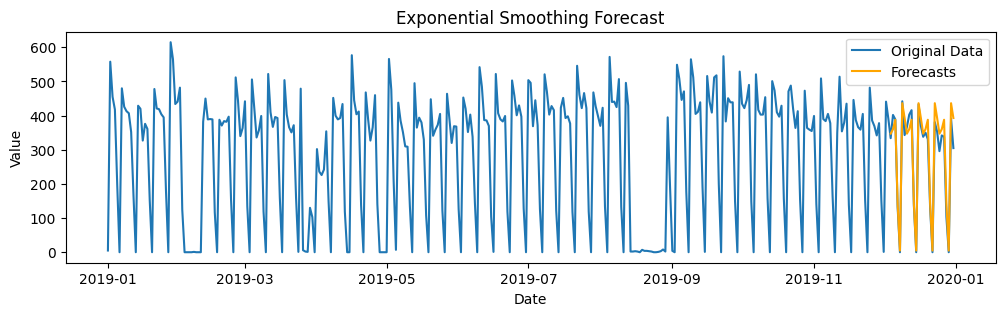

In [34]:
# Fit the exponential smoothing model on the training data
es_model = ExponentialSmoothing(y_train, trend=None, seasonal='additive', seasonal_periods=7)
result = es_model.fit()

# Get the forecasts for the test set
y_pred = result.forecast(steps=len(y_test))

# Plot the original data, forecasts, and test set
plt.figure(figsize=(12, 3))
plt.plot(es_df.index, es_df, label='Original Data')
plt.plot(y_test.index, y_pred, label='Forecasts', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Exponential Smoothing Forecast')
plt.show()

In [35]:
r2_score(y_test, y_pred)

0.9438215737988772